In [17]:
import logging
import sys
from pathlib import Path
import itertools

import click
import numpy as np
import pandas as pd
import rasterra as rt
from rra_tools import jobmon
from scipy.special import expit
import xarray as xr
import tqdm
import geopandas as gpd

from spatial_temp_cgf import paths
from spatial_temp_cgf.training_data_prep import income_funcs
from spatial_temp_cgf.training_data_prep.location_mapping import load_fhs_lsae_mapping
from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf.data import DEFAULT_ROOT, ClimateMalnutritionData

from spatial_temp_cgf.inference.run_inference import (
    FHS_SHAPE_PATH,
    RASTER_TEMPLATE_PATH,
    SHAPE_PATH,
    LDIPC_FILEPATH,
    xarray_to_raster, 
    load_ldi,
)

In [37]:
GLOBAL_POP_PATH = "/mnt/team/rapidresponse/pub/population/data/01-raw-data/other-gridded-pop-projects/global-human-settlement-layer/1km_population.tif"

In [2]:
output_dir = Path(DEFAULT_ROOT)
measure = 'stunting'
model_version = "2024_07_01.05"
cmip6_scenario = 'ssp126'
year = 2025

In [3]:
cm_data = ClimateMalnutritionData(output_dir/ measure)
spec = cm_data.load_model_specification(model_version)

print('loading raster template')
raster_template = rt.load_raster(RASTER_TEMPLATE_PATH)
print('loading models')
models = cm_data.load_model_family(model_version)

loading raster template
loading models


In [4]:
coefs = models[0]['model'].coefs['Estimate'].to_dict()

In [5]:
print('loading predictors')
m = models[0]
variables = {}
for variable, info in m['model'].var_info.items():
    print(variable)
    if variable == 'intercept':
        continue
    elif variable == 'ldi_pc_pd':
        v = load_ldi(cm_data, year)
    else:
        subfolder = cmip6_scenario if year >= 2024 else 'historical'
        path = paths.CLIMATE_PROJECTIONS_ROOT / subfolder / "mean_temperature" / f"{year}.nc"
        v_ds = xr.open_dataset(path).sel(year=year)['value']
        v = xarray_to_raster(v_ds, nodata=np.nan).resample_to(raster_template).to_numpy()
    v = info['transformer'](v)
    variables[variable] = v

loading predictors
intercept
mean_temperature
ldi_pc_pd


In [6]:
coefs

{'(Intercept)': -0.9014191335266458,
 'mean_temperature': -0.40970033315210175,
 'ldi_pc_pd': 3.1740257239731307,
 'mean_temperature:ldi_pc_pd': -7.790186489353465}

In [7]:
z = (
    coefs['(Intercept)'] 
    + coefs['mean_temperature'] * variables['mean_temperature']
    + coefs['ldi_pc_pd'] * variables['ldi_pc_pd']
    + coefs['mean_temperature:ldi_pc_pd'] * variables['ldi_pc_pd'] * variables['mean_temperature']
)

In [8]:
p = rt.RasterArray(
    1 / (1 + np.exp(-z)),
    transform=raster_template.transform,
    crs=raster_template.crs,
    no_data_value=raster_template.no_data_value,
)

In [38]:
print("loading fhs shape data")
fhs_shapes = gpd.read_parquet(FHS_SHAPE_PATH).set_index('loc_id').geometry.to_dict()
print("loading population")
fhs_pop_raster = rt.load_raster(GLOBAL_POP_PATH)

loading fhs shape data
loading population


In [44]:
count = p * fhs_pop_raster
save_raster(count.astype(np.float32), 'count.tif')

In [51]:
def make_prevalence(shape):
    s_id, shape = shape    
    count = rt.load_raster('count.tif', shape.bounds).mask(shape)
    numerator = np.nansum(count)
    pop = rt.load_raster(GLOBAL_POP_PATH, shape.bounds).mask(shape)
    denominator = np.nansum(pop)
    return numerator / denominator
    

In [52]:
from rra_tools import parallel

In [54]:
to_run = list(fhs_shapes.items())
vals = parallel.run_parallel(
    make_prevalence,
    to_run,
    num_cores=10, 
    progress_bar=True    
)


100%|████████████████████████████████████████████████████████████| 1047/1047 [01:12<00:00, 14.41it/s]


In [59]:
gdf = gpd.GeoDataFrame(
    [(shape_id, shape, vals[i]) for i, (shape_id, shape) in enumerate(fhs_shapes.items())],
    columns=['shape_id', 'geometry', 'prevalence'], crs='EPSG:4326',
)

<Axes: >

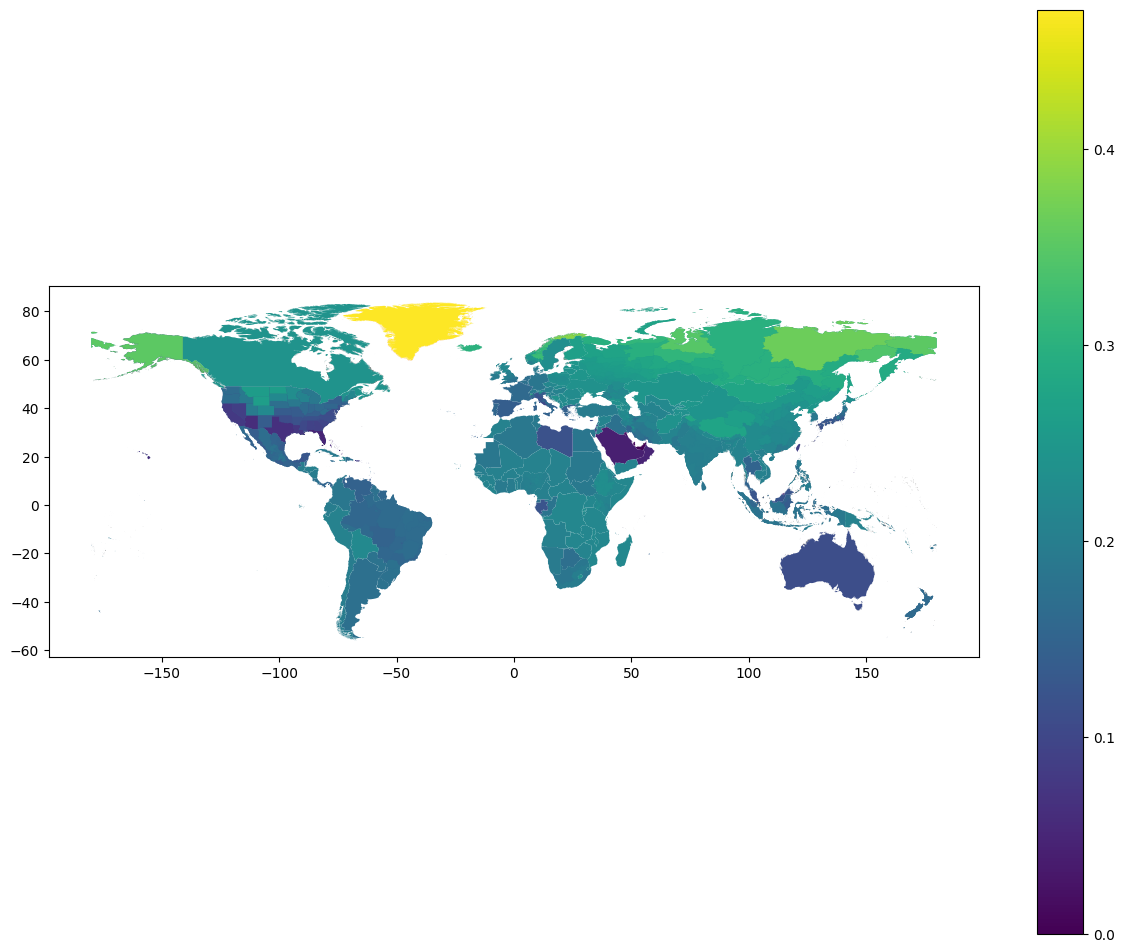

In [62]:
fig, ax = plt.subplots(figsize=(15, 12))
gdf.plot(column='prevalence', ax=ax, legend=True)

In [41]:
import tqdm
print('Computing zonal statistics')
out = []
for model_dict in models[:1]:
    count = p * fhs_pop_raster
    for shape_id, shape in tqdm.tqdm(list(fhs_shapes.items())):
        numerator = np.nansum(count.clip(shape).mask(shape))
        denominator = np.nansum(fhs_pop_raster.clip(shape).mask(shape))
        out.append((
            shape_id,
            model_dict['age_group_id'],
            model_dict['sex_id'],
            numerator / denominator,
        ))

Computing zonal statistics


  2%|▉                                                           | 16/1047 [02:37<2:49:03,  9.84s/it]


KeyboardInterrupt: 

In [ ]:
fhs_pop_raster

In [20]:
p.transform

Affine(0.01, 0.0, -180.0,
       0.0, -0.01, 90.0)

In [12]:
ldi = rt.RasterArray(
    variables['ldi_pc_pd'],
    transform=raster_template.transform,
    crs=raster_template.crs,
    no_data_value=raster_template.no_data_value,
)

<Axes: >

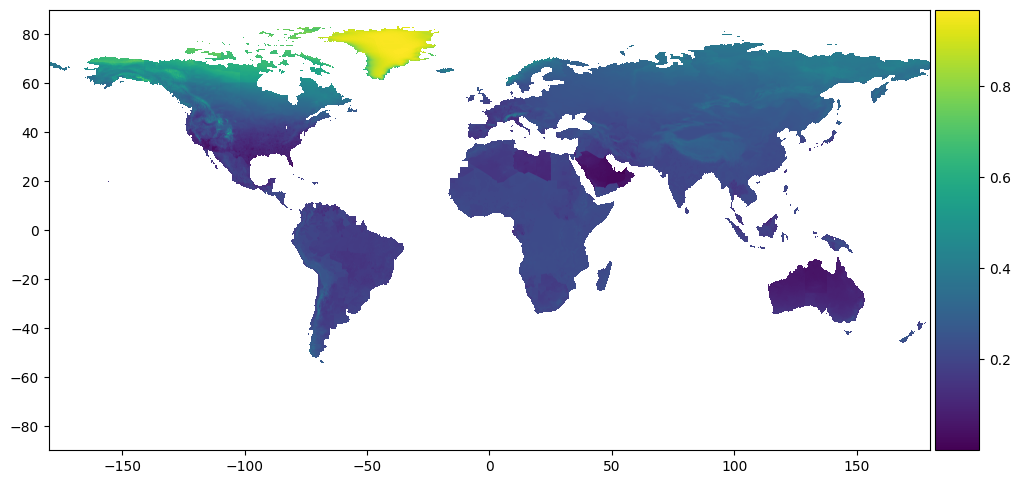

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
p.plot(ax=ax)

<Axes: >

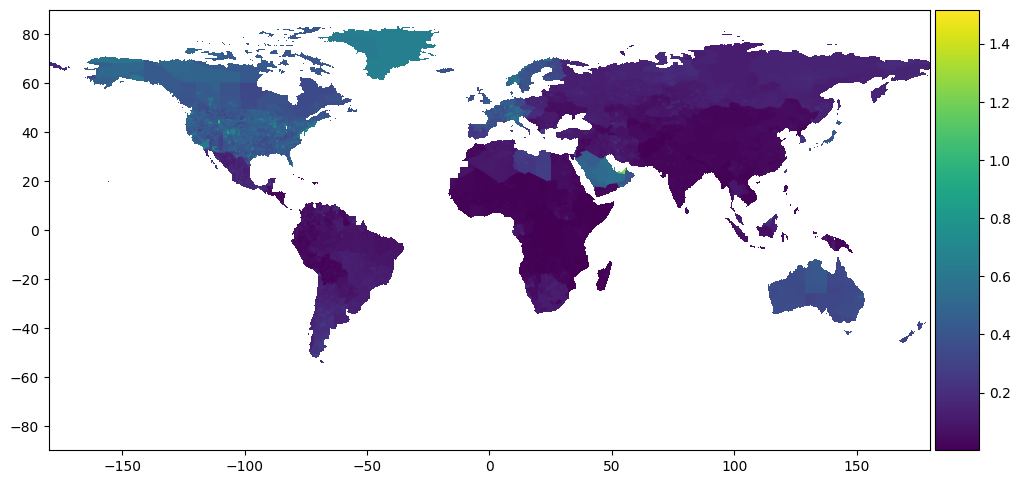

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ldi.plot(ax=ax)